<a href="https://colab.research.google.com/github/Megancodes2017/Megancodes2017/blob/main/Scouting_Report(DodgersvsS%C3%A1nchez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pybaseball

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.7/432.7 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pybaseball import statcast_batter, statcast_pitcher, playerid_lookup

In [3]:
pid_df = playerid_lookup('Sánchez', 'Cristopher')
print(pid_df[['name_last', 'name_first', 'key_mlbam']])

Gathering player lookup table. This may take a moment.
  name_last  name_first  key_mlbam
0   sánchez  cristopher     650911


In [4]:
pid = pid_df['key_mlbam'].iloc[0]

In [5]:
# Get Sánchez's pitch data from 2025 season
start_date = '2025-03-20'
end_date = '2025-09-30'
pitches = statcast_pitcher(start_date, end_date, pid)

Gathering Player Data


In [20]:
# Summarize Sánchez's pitch arsenal
cris_summary = (
    pitches.groupby('pitch_type')
    .agg(
        usage=('pitch_type', 'size'),
        avg_velo=('release_speed', 'mean'),
        avg_spin=('release_spin_rate', 'mean'),
        whiff_rate=('description', lambda x: x.str.contains('swinging_strike').sum() / x.str.contains('swing|foul|hit_into_play|missed_bunt').sum()),
        avg_xwoba=('estimated_woba_using_speedangle', 'mean')
    )
)

cris_summary['usage_pct'] = cris_summary['usage'] / cris_summary['usage'].sum()
print(cris_summary)

            usage   avg_velo     avg_spin  whiff_rate  avg_xwoba  usage_pct
pitch_type                                                                 
CH           1083  86.276824  2043.280961    0.424497   0.207648   0.373964
SI           1332  95.384899  2137.231231    0.121870   0.326598   0.459945
SL            481  85.675052  2088.336798    0.319328   0.318012   0.166091


In [21]:
# Get Dodgers hitters MLBAM IDs and 2025 splits
dodgers_hitters = [
    'Shohei Ohtani', 'Max Muncy', 'Will Smith', 'Freddie Freeman', 'Enrique Hernández',
    'Teoscar Hernández', 'Mookie Betts', 'Andy Pages', 'Tommy Edman', 'Alex Call',
    'Miguel Rojas', 'Hyeseong Kim', 'Ben Rortvedt'
]

ids = {}
for h in dodgers_hitters:
  pid_df = playerid_lookup(h.split()[1], h.split()[0])
  if not pid_df.empty:
    ids[h] = pid_df['key_mlbam'].values[0]
  else:
    print(f'Could not find MLBAM ID for {h}')

print(ids)

{'Shohei Ohtani': np.int64(660271), 'Max Muncy': np.int64(571970), 'Will Smith': np.int64(519293), 'Freddie Freeman': np.int64(518692), 'Enrique Hernández': np.int64(571771), 'Teoscar Hernández': np.int64(606192), 'Mookie Betts': np.int64(605141), 'Andy Pages': np.int64(681624), 'Tommy Edman': np.int64(669242), 'Alex Call': np.int64(669743), 'Miguel Rojas': np.int64(500743), 'Hyeseong Kim': np.int64(808975), 'Ben Rortvedt': np.int64(666163)}


In [22]:
# Pull matchup splits vs pitch types
def hitter_splits(hitter_id, start='2025-03-18', end='2025-09-29'):
  df = statcast_batter(start,end, hitter_id)
  return (
      df.groupby('pitch_type')
      .agg(
          swings=('description', lambda x: sum(x.str.contains('swing'))),
          whiffs=('description', lambda x: sum(x.str.contains('swining_strike'))),
          total_pitches=('pitch_type', 'size'),
          avg_xwoba=('estimated_woba_using_speedangle', 'mean')
      )
      .assign(whiff_rate=lambda d: d['whiffs']/d['total_pitches'].replace(0,1))
  )

hitter_reports = {h: hitter_splits(ids[h], start='2025-03-18', end='2025-09-29') for h in dodgers_hitters if h in ids}

Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data


In [23]:
# Compare Sánchez's pitch effectiveness vs Dodger's hitters
report = {}
for hitter, df in hitter_reports.items():
  merged = df.join(cris_summary, how='inner', rsuffix='_cris')
  report[hitter] = merged[['avg_xwoba', 'whiff_rate', 'avg_xwoba_cris', 'whiff_rate_cris']]

In [24]:
# Generate scouting report
for hitter, df in report.items():
  print(f'\n---{hitter} ---')
  for pitch in df.index:
    h_xwoba = df.loc[pitch, 'avg_xwoba']
    c_xwoba = df.loc[pitch, 'avg_xwoba_cris']
    if h_xwoba > 0.324:
      print(f'{hitter} hits the {pitch} well (xwOBA {h_xwoba:.3f}), risk pitch.')
    elif h_xwoba < 0.300:
      print(f'{hitter} struggles vs {pitch} (xwoba {h_xwoba:.3f}), good matchup for Sánchez.')


---Shohei Ohtani ---
Shohei Ohtani hits the CH well (xwOBA 0.378), risk pitch.
Shohei Ohtani hits the SI well (xwOBA 0.428), risk pitch.
Shohei Ohtani hits the SL well (xwOBA 0.447), risk pitch.

---Max Muncy ---
Max Muncy hits the CH well (xwOBA 0.425), risk pitch.
Max Muncy hits the SI well (xwOBA 0.525), risk pitch.
Max Muncy struggles vs SL (xwoba 0.291), good matchup for Sánchez.

---Will Smith ---

---Freddie Freeman ---
Freddie Freeman hits the SI well (xwOBA 0.370), risk pitch.
Freddie Freeman hits the SL well (xwOBA 0.338), risk pitch.

---Enrique Hernández ---
Enrique Hernández hits the CH well (xwOBA 0.336), risk pitch.
Enrique Hernández struggles vs SI (xwoba 0.260), good matchup for Sánchez.
Enrique Hernández struggles vs SL (xwoba 0.211), good matchup for Sánchez.

---Teoscar Hernández ---
Teoscar Hernández struggles vs CH (xwoba 0.280), good matchup for Sánchez.
Teoscar Hernández hits the SI well (xwOBA 0.374), risk pitch.
Teoscar Hernández struggles vs SL (xwoba 0.288)

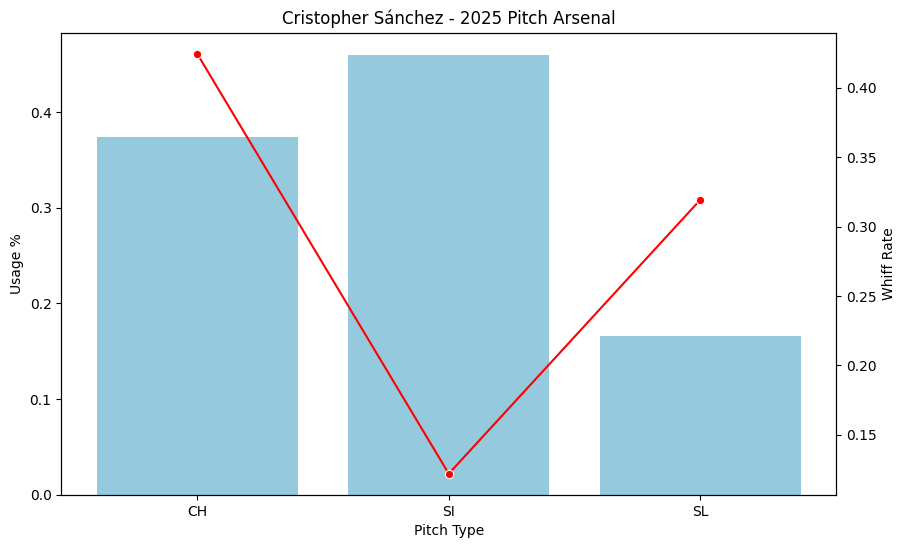

In [25]:
# Sánchez arsenal chart
# reset index for plotting
arsenal = cris_summary.reset_index()

fig, ax1 = plt.subplots(figsize=(10,6))
sns.barplot(data=arsenal, x='pitch_type', y='usage_pct', ax=ax1, color='skyblue')
ax1.set_ylabel('Usage %')
ax1.set_xlabel('Pitch Type')
ax1.set_title('Cristopher Sánchez - 2025 Pitch Arsenal')

# Overlay average whiff rate
ax2=ax1.twinx()
sns.lineplot(data=arsenal, x='pitch_type', y='whiff_rate', ax=ax2, color='red', marker='o')
ax2.set_ylabel('Whiff Rate')

plt.show()